# External Monotonic

---

---

### Overview

This notebook trains a similar network to [mixed_monotonic](./mixed_monotonic.ipynb), but with a third party library [`TabTransformer`](https://github.com/lucidrains/tab-transformer-pytorch) as the non-monotonic network (rather than a simple user-defined embedding network).

Notice:
- We're importing `MixedMonotonicNet()` from `tabularasa`.  However, we'll define a class that inherits from this to align with `TabTransformer` inputs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tabularasa.MixedMonotonic import MixedMonotonicRegressor, MixedMonotonicNet
from tab_transformer_pytorch import TabTransformer

---

### Load example data

If you haven't already, please generate the example dataset using the [example_data](example_data.ipynb) notebook.

In [2]:
df = pd.read_pickle('./data/simple_train.pkl')

---

### Define the mixed monotonic network to interoperate with `TabTransformer`

Looking at the source code for `MixedMonotonicNet`, we can see we need to rewrite the `.forward()` method.  Instead of passing a single argument `X_non_monotonic`, inputs are broken up into `X_categorical` and `X_non_monotonic`.  This is to map to `TabTransformer`s arguments of `x_categ` and `x_cont`, which serves as are non-monotonic network.  Afterward, we can continue to send the outputs from `TabTransformer` as inputs to our monotonic model.

In [8]:
class CustomMixedMonotonicNet(MixedMonotonicNet):

    def forward(self, X_monotonic, X_categorical, X_non_monotonic, last_hidden_layer=False):
        h = self.non_monotonic_net(x_categ=X_categorical, x_cont=X_non_monotonic)
        return self.monotonic_net(X_monotonic, h, last_hidden_layer)

Now, when initializing `MixedMonotonicRegressor()`, we need to pass:
- `module`: should now be our `CustomMixedMonotonicNet`.
- `non_monotonic_net`: should now be `TabTransformer()`, which requires several of its own inputs.

In [9]:
model = MixedMonotonicRegressor(CustomMixedMonotonicNet,
                                max_epochs=150,
                                lr=0.01,
                                optimizer=torch.optim.Adam,
                                iterator_train__shuffle=True,
                                module__non_monotonic_net=TabTransformer(categories=(50,),
                                                                         num_continuous=1,
                                                                         dim=16,
                                                                         dim_out=16,
                                                                         depth=6,
                                                                         heads=8,
                                                                         attn_dropout=0.1,
                                                                         ff_dropout=0.1,
                                                                         mlp_hidden_mults=(4, 2),
                                                                         mlp_act=nn.ReLU()),
                                module__dim_non_monotonic=16,
                                module__dim_monotonic=2,
                                module__layers=[128, 128, 32],
                                module__integration_steps=300)

The `.forward()` pass now has 3 keys.

In [10]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_categorical': df[['x3']].values,
           'X_non_monotonic': df[['x4']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4001        0.2633  8.0191
      2        0.2378        0.1617  7.4229
      3        0.1449        0.0870  6.9614
      4        0.1038        0.1072  7.1651
      5        0.1122        0.1027  7.2826
      6        0.0980        0.0898  7.1615
      7        0.0972        0.0814  7.2189
      8        0.0945        0.0776  7.1620
      9        0.0930        0.0762  7.3575
     10        0.0896        0.0763  7.2404
     11        0.0896        0.0761  7.0147
     12        0.0887        0.0757  7.2891
     13        0.0893        0.0822  7.4428
     14        0.0906        0.0789  7.8128
     15        0.0894        0.0759  6.7117
     16        0.0887        0.0759  6.8119
     17        0.0890        0.0756  6.7474
     18        0.0895        0.0754  6.7389
     19        0.0897        0.0810  6.6912
     20        0.0923        0.0878  6.7305
     21        0.0897        0.0

<class 'tabularasa.MixedMonotonic.MixedMonotonicRegressor'>[initialized](
  module_=CustomMixedMonotonicNet(
    (non_monotonic_net): TabTransformer(
      (norm): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (embeds): Embedding(52, 16)
        (layers): ModuleList(
          (0): ModuleList(
            (0): Residual(
              (fn): PreNorm(
                (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
                (fn): Attention(
                  (to_qkv): Linear(in_features=16, out_features=384, bias=False)
                  (to_out): Linear(in_features=128, out_features=16, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
              )
            )
            (1): Residual(
              (fn): PreNorm(
                (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
                (fn): FeedForward(
                  (net): Sequential(
                  

We'll create a partial dependence plot to visualize how the monotonic network constrained our relationship between `x1` and `y`.

In [11]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [13]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_categorical': dfc[['x3']].values,
                       'X_non_monotonic': dfc[['x4']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

We can see below that, unlike with the simple MLP network, we have a monotonically increasing relationship between `x1` and `y`.

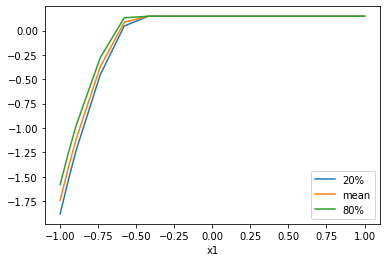

In [14]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

The next [example](./tabula_rasa.ipynb) walks through `TabulaRasaRegressor()`, which combines logic from all prior examples into a single, easy-to-use class.